In [32]:
# import all relevant libraries
import pandas as pd
import numpy as np
import uuid
import re
import json
from pandas.plotting import register_matplotlib_converters
from pandas import json_normalize
import matplotlib.pyplot as plt

charging = pd.read_csv("charging_cleaned.csv", encoding = "ISO-8859-1")

In [33]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])

<h1> Task 2 </h2>

<h2> Task 2 a.) - Showing daily demand

2 approaches for daily demand: 

1. show every single hour
2. divide day in morning, noon ect.

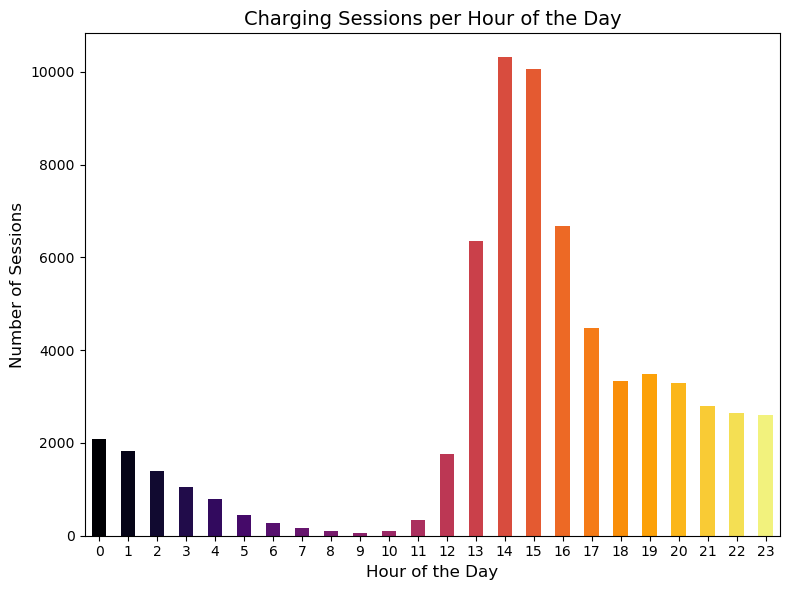

In [34]:
#first approach
charging['hour_of_day'] = charging['connectionTime'].dt.hour

cmap = plt.get_cmap("inferno")  # You can change this to any other colormap like 'plasma', 'inferno', etc.
colors = [cmap(i / 24) for i in range(24)]

plt.figure(figsize=(8, 6))
sessions_per_hour = charging.groupby('hour_of_day').size()

sessions_per_hour.plot(kind='bar', color=colors)

plt.xticks(range(0, 24), rotation=0)
plt.title('Charging Sessions per Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()



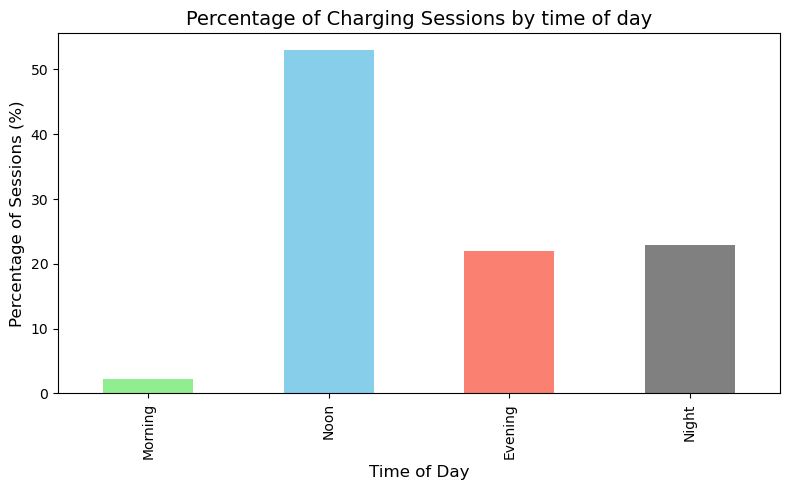

In [35]:
def classify_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

charging['time_of_day'] = charging['connectionTime'].dt.hour.apply(classify_time_of_day)

# Number of charging sessions for each time of day
time_of_day_counts = charging['time_of_day'].value_counts().reindex(['Morning', 'Noon', 'Evening', 'Night'])

# Calculate percentage of each category
time_of_day_percentage = (time_of_day_counts / time_of_day_counts.sum()) * 100

# create bar chart
plt.figure(figsize=(8, 5))  
time_of_day_percentage.plot(kind='bar', color=['lightgreen', 'skyblue', 'salmon', 'gray'])

plt.title('Percentage of Charging Sessions by time of day', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Percentage of Sessions (%)', fontsize=12)
plt.tight_layout()
plt.show()


<h5>Interpretation</h5>

Regardless of the approach, we see that there is a **pattern in daily use**. In the early morning hours the demand is at its lowest and the demand increases as we reach Noon. The **peak time** of demand is the Noon time around 12pm to 6pm and in the evening from 6pm on the demand decreases linearly until the next day on 10am right before noon

In my opinion, the second approach (dividing day into 4 parts isntead of showing the demand hourly) is superior because we have longer intervals here and some processes might start at 10:59:59 and still are assigned to 10pm. With the divison based on intervals, we don't have these problems (or at least not as often)

<h2> Task 2 a.) - Showing weekly demand

The problem here is that 42% of the sessions start on one day and end in the next day or longer, so it isn't optimal to assign day belonging based on connection time

In [36]:
#count the percentage of sessions that go over multiple days
sessions_spanning_midnight = len(charging[charging['connectionTime'].dt.date != charging['disconnectTime'].dt.date])
percentage_spanning_midnight = (sessions_spanning_midnight / len(charging)) * 100

print(percentage_spanning_midnight)

42.27088036117381


<h4>Approach for showing weekly demand </h4>

The problem here is that some sessions might start at 23:59 and if we would only regard "connectionTime" for day belonging, some sessions which begin at 23:59 are assigned to this day which isn't accurate. 

My proposed soluton: for each row/session, compute the duration (disconnectTime-connectTime) and we assign the session to the day where the **majority of the charging duration** occured

Monday: 11095 sessions
Tuesday: 12826 sessions
Wednesday: 12661 sessions
Thursday: 12632 sessions
Friday: 10989 sessions
Saturday: 3600 sessions
Sunday: 2647 sessions


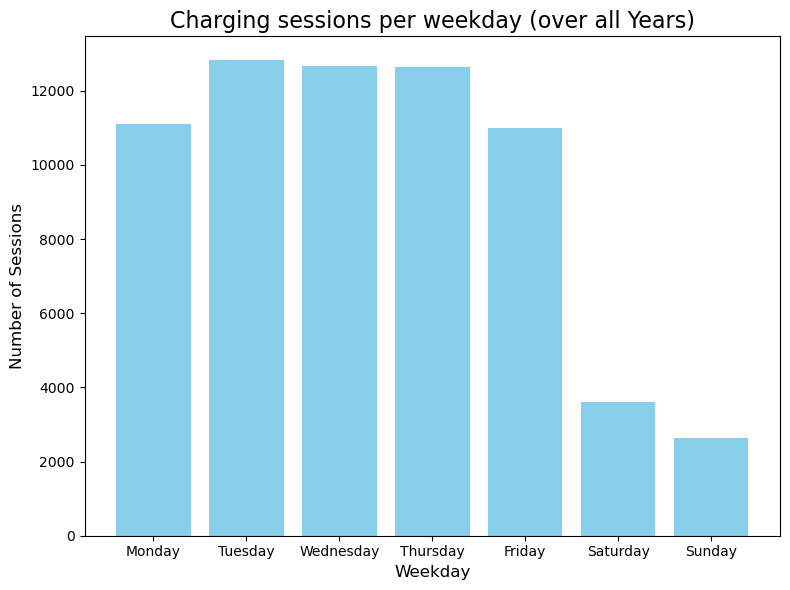

In [37]:
weekday_counts = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}

for index, row in charging.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    
    # Calculate duration of particular session
    duration = disconnect_time - connection_time
    
    # Case 1: session is on the same day. if yes, we can stop here
    if connection_time.date() == disconnect_time.date():
        # Add to the weekday of the connection time
        weekday_counts[connection_time.strftime('%A')] += 1
    
    # Case 2: Session spanning multiple days
    else:
        # Split the duration into two parts:  
        # First part is from connetcion time to midnight of the same day
        # Second part is from midnight to disconnect time on the next day
        
        
        midnight_same_day = connection_time.replace(hour=23, minute=59, second=59)
        duration_first_day = midnight_same_day - connection_time
        
        midnight_on_next_day = disconnect_time.replace(hour=0, minute=0, second=0)
        duration_second_day = disconnect_time - midnight_on_next_day
        
        if duration_first_day > duration_second_day:
            weekday_counts[connection_time.strftime('%A')] += 1
        else:
            weekday_counts[disconnect_time.strftime('%A')] += 1


for day, count in weekday_counts.items():
    print(f"{day}: {count} sessions")


plt.figure(figsize=(8, 6))
plt.bar(weekday_counts.keys(), weekday_counts.values(), color='skyblue')
plt.title('Charging sessions per weekday (over all Years)', fontsize=16)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()


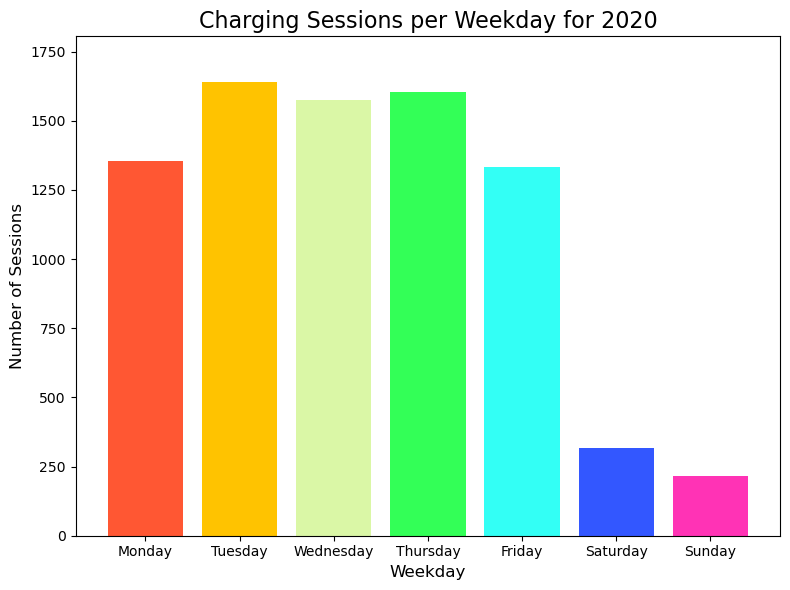

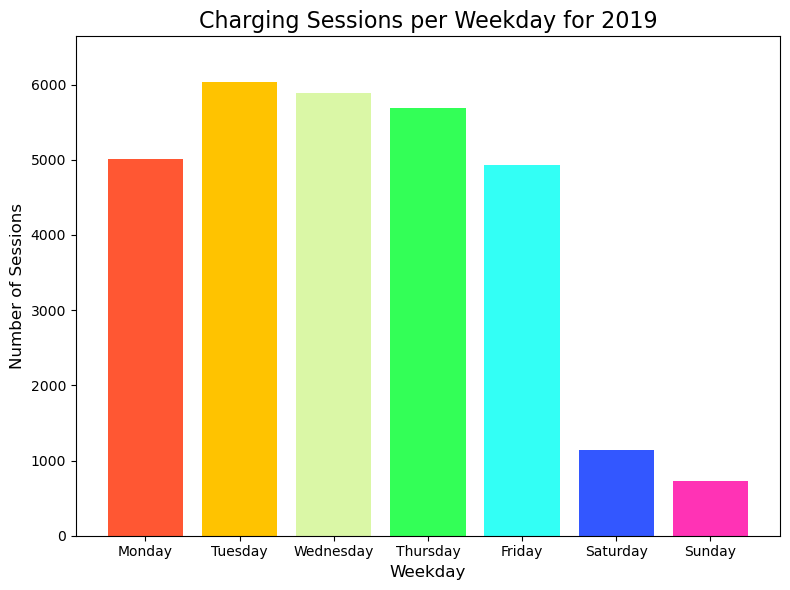

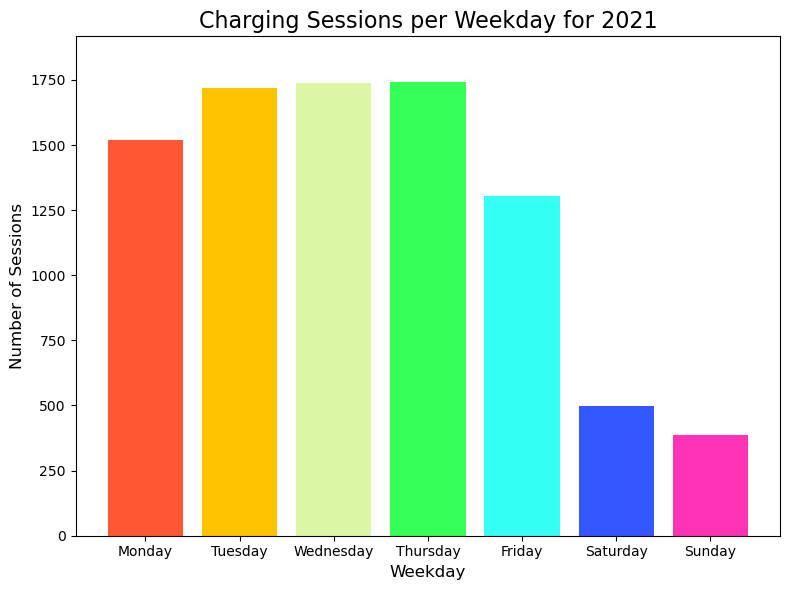

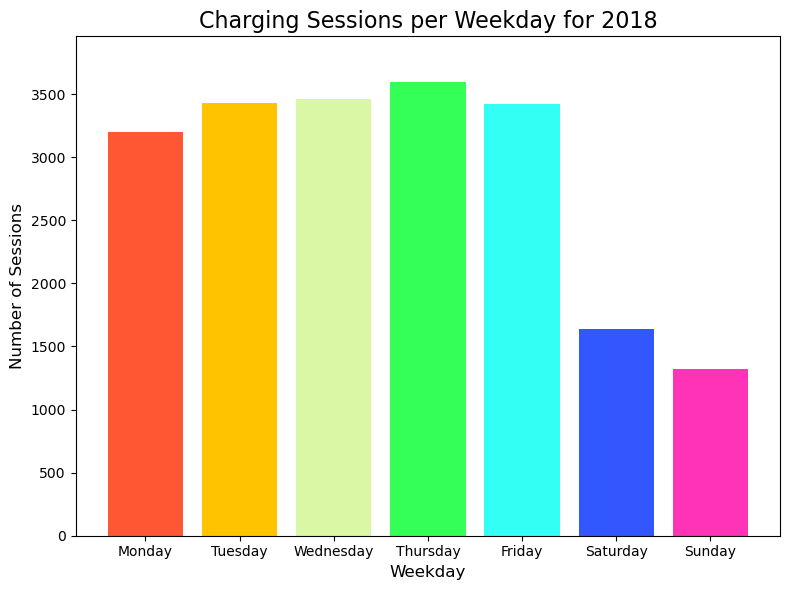

In [38]:
#grouping the weeks by year (just for testing). here wo would have to normalize

yearly_weekday_counts = {}

for index, row in charging.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    
    duration = disconnect_time - connection_time
    
    year = connection_time.year
    
    if year not in yearly_weekday_counts:
        yearly_weekday_counts[year] = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}
    
    if connection_time.date() == disconnect_time.date():
        weekday = connection_time.strftime('%A')
        yearly_weekday_counts[year][weekday] += 1
    
    else:
        midnight_same_day = connection_time.replace(hour=23, minute=59, second=59)
        duration_first_day = midnight_same_day - connection_time
        midnight_on_next_day = disconnect_time.replace(hour=0, minute=0, second=0)
        duration_second_day = disconnect_time - midnight_on_next_day
        
        if duration_first_day > duration_second_day:
            weekday = connection_time.strftime('%A')
        else:
            weekday = disconnect_time.strftime('%A')
        
        yearly_weekday_counts[year][weekday] += 1

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

colors = ['#FF5733', '#FFC300', '#DAF7A6', '#33FF57', '#33FFF5', '#3357FF', '#FF33B5']


for year, counts in yearly_weekday_counts.items():
    plt.figure(figsize=(8, 6))
    plt.bar(weekdays, counts.values(), color=colors)    
    plt.title(f'Charging Sessions per Weekday for {year}', fontsize=16)
    plt.xlabel('Weekday', fontsize=12)
    plt.ylabel('Number of Sessions', fontsize=12)  
    plt.ylim(0, max(max(counts.values()) * 1.1, 25))  
    
    plt.tight_layout()
    plt.show()




Regardless of the which approach, we can clearly see that the **peak days are tuesday, wednesday and thursday.** On the weekend, demand isn't that hight. Intuitively, this makes sense as most people would use their E-Cars on weekdays.

**Interestingly, the proportion of sessions in year 2018 on the weekend were higher than in the next years**

<h2> Task 2 a.) - Showing season patterns

Proposed approaches: 
1. Divide year in summer, spring, winter and autumn and show numbers (for each year)
2. Show monthly number of sessions over the year
3. Show the number of sessions over the years(i.e. for each year)

Try approach 1 and 2


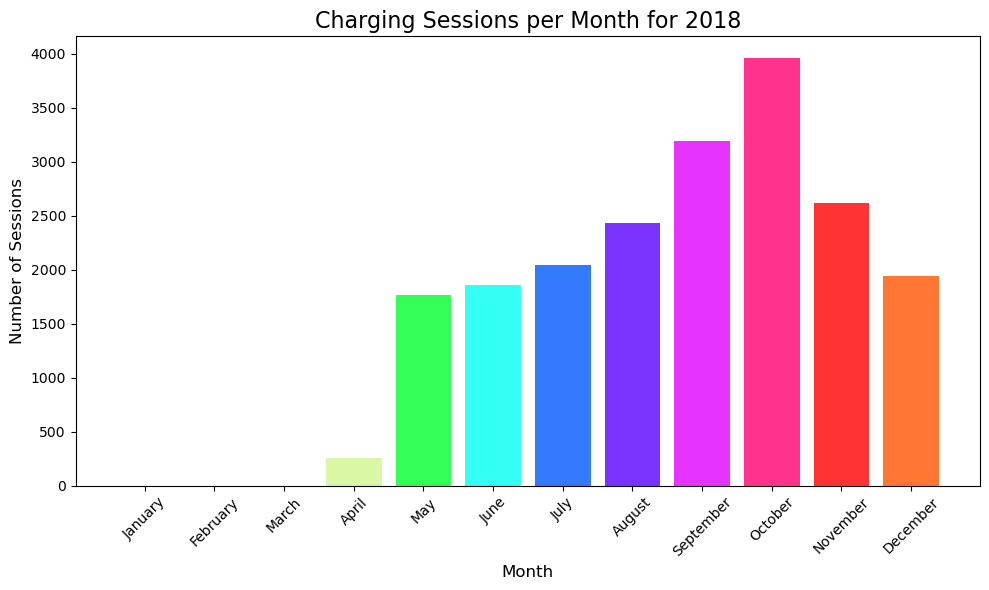

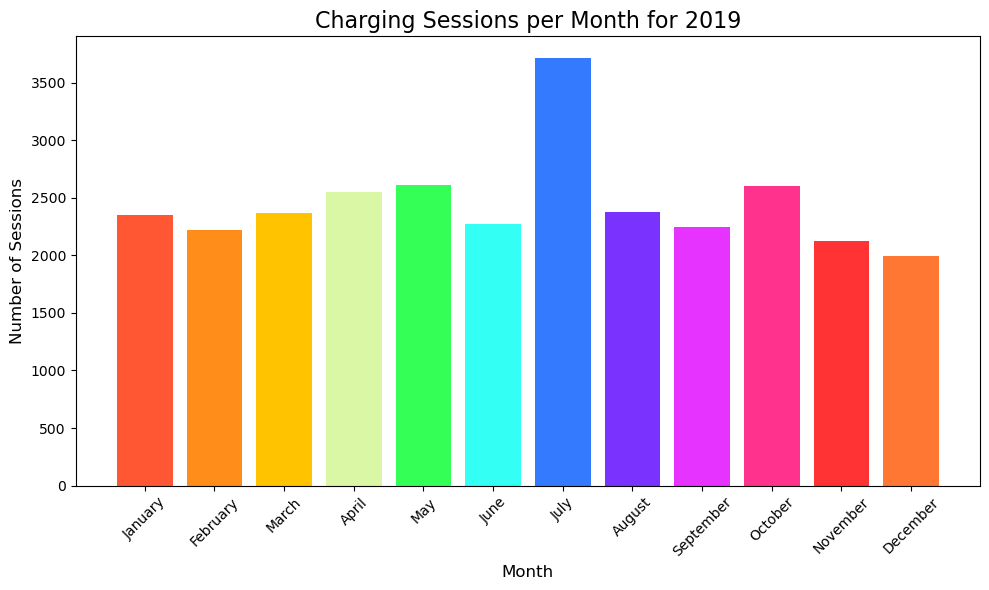

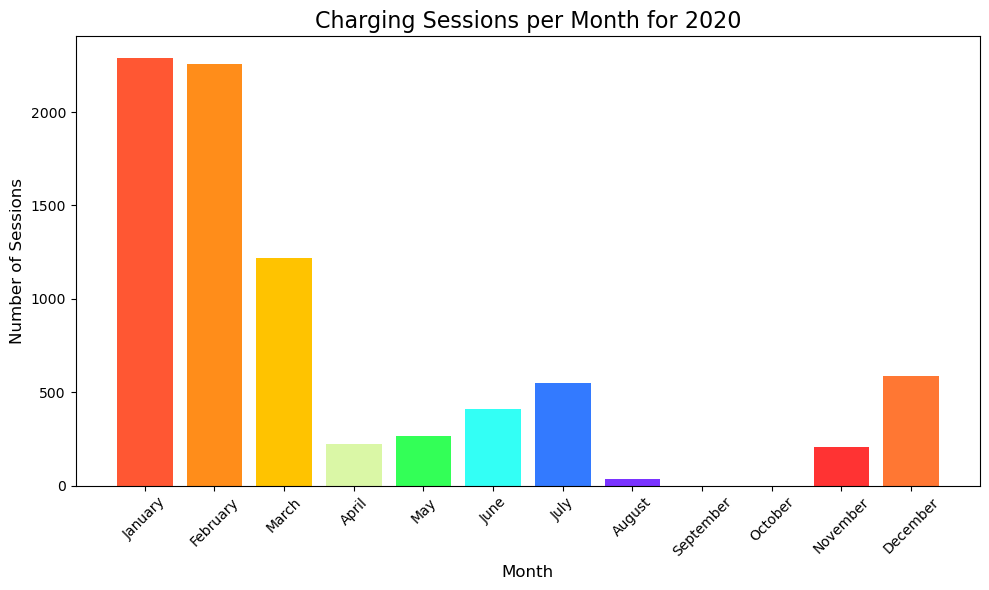

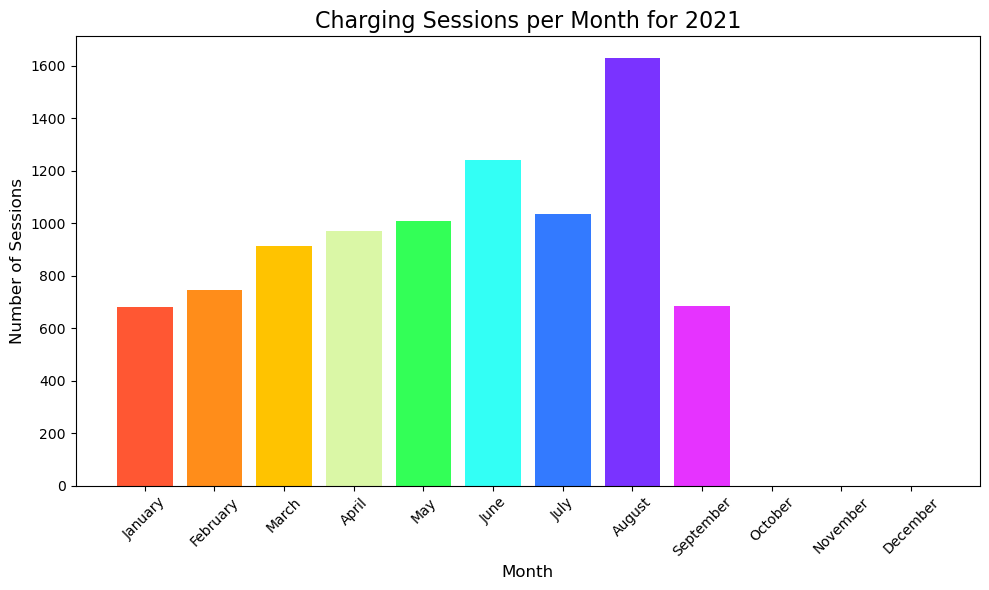

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar


# Approach 1
''''
def get_season(date):
    if (date.month == 12 and date.day >= 21) or (date.month <= 3 and date.month >= 1):
        return 'Winter'
    elif 3 <= date.month <= 5:
        return 'Spring'
    elif 6 <= date.month <= 8:
        return 'Summer'
    elif 9 <= date.month <= 11:
        return 'Fall'

charging['season'] = charging['connectionTime'].apply(get_season)
charging['year'] = charging['connectionTime'].dt.year
seasonal_trends = charging.groupby(['year', 'season']).size().unstack(fill_value=0)
seasonal_trends.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title('Seasonal charging sessions trends over the years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
'''







#approach 2
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

charging['year'] = charging['connectionTime'].dt.year
charging['month'] = charging['connectionTime'].dt.month

yearly_monthly_counts = charging.groupby(['year', 'month']).size().unstack(fill_value=0)

month_colors = [
    '#FF5733', '#FF8D1A', '#FFC300', '#DAF7A6', '#33FF57',
    '#33FFF5', '#337AFF', '#7A33FF', '#E633FF', '#FF338D',
    '#FF3333', '#FF7733'
]

for year, counts in yearly_monthly_counts.iterrows():
    plt.figure(figsize=(10, 6))
    months = [calendar.month_name[i] for i in range(1, 13)]
    plt.bar(months, counts, color=month_colors)
    
    plt.title(f'Charging Sessions per Month for {year}', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Sessions', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



<h4>Interpretation</h4>

We see multiple things:

1. 2018 and 2019 had more sessions than the other years -> In year 2020 pandemic started and this could have resulted in a reduction commuting and traveling, reduction imports for material for these vehicles ect. so the use of e-vehicles also decreased from 2020 on

2. **Some month are not recorded in the data, such as the first three months of 2018 and the last 3 months of 2021 and september + october of 2020 -> why?**

3. In year 2020, the demand significantly went down from april on and stayed on a very low level for the rest of the year -> can be attributed to covid

4. In year 2021, chargign sessions went up again -> "recovery" from covid, restrictions weren't that strict anymore

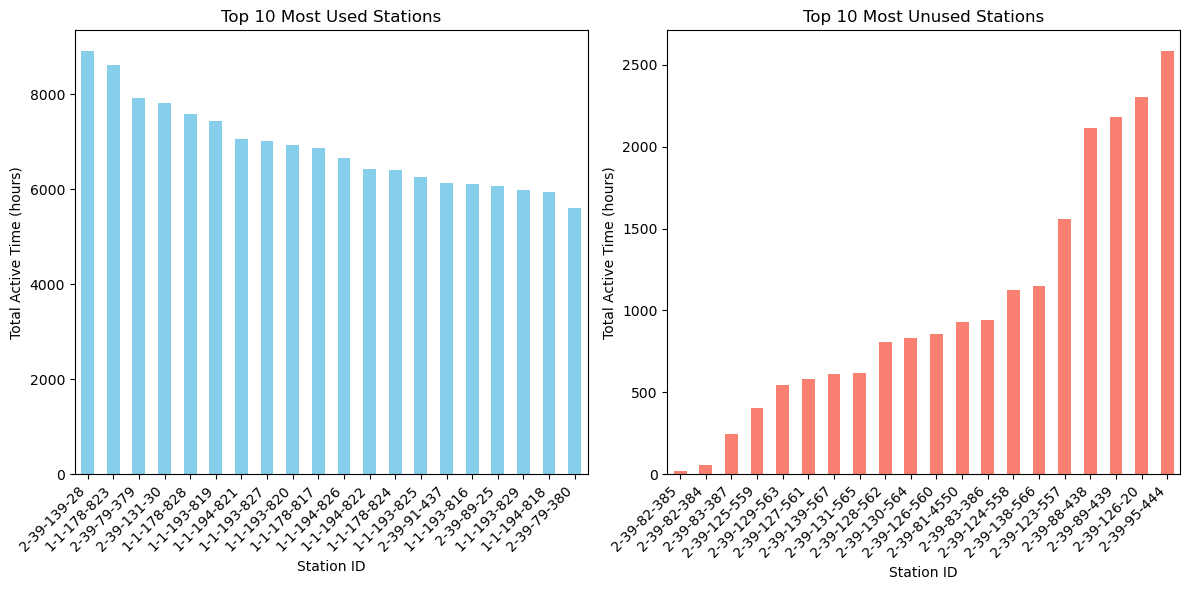

In [40]:
charging['duration'] = (charging['disconnectTime'] - charging['connectionTime']).dt.total_seconds() / 3600

station_active_time = charging.groupby('stationID')['duration'].sum()

most_used_stations = station_active_time.sort_values(ascending=False).head(20)

most_unused_stations = station_active_time.sort_values(ascending=True).head(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
most_used_stations.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Used Stations')
plt.xlabel('Station ID')
plt.ylabel('Total Active Time (hours)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
most_unused_stations.plot(kind='bar', color='salmon')
plt.title('Top 10 Most Unused Stations')
plt.xlabel('Station ID')
plt.ylabel('Total Active Time (hours)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


As we can see, stations of site 1 are much more used than stations of site 2 -> indication that site 2 might be the private site

<h2> Task 2 b.) - KPI

<h2> Task

<p>Some KPI's which could be used:

<ol>
<li> kwh delivered total of the session -> total amount of energy given by chargers over a given period </li>
<li> Average charging Sessions per Day -> Formula: (Total active time / Total available time) * 100.</li>
<li> Station use rate -> Percentage of total charging stations which are occupied at a time </li>
<li> Utilization Rate -> percentage of time a station is used vs. the total available time so customers can be directed to these stations in times of high demand</li>
</ol>

Source: 
1. https://ampup.io/blog/how-to-use-key-performance-indicators-kpis-to-optimize-your-ev-charging-stations

2. https://www.researchgate.net/publication/325197814_Key_Performance_Indicators_of_Charging_infrastructure

<h2> Task 2 c.) Site

Site 2 is probably the private site.

From the code above we can see that the top most unused stations are from site 2. we can assume that the private site is less used because it is not openly accessible. 

We can also see that Site 1 delivers much more energy than site 2, indicating that site 1 is more used 

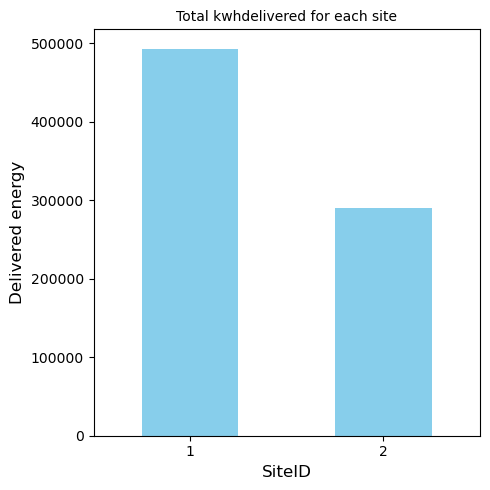

In [41]:
charging.head()
null_counts_per_site = charging.groupby('siteID')["kWhDelivered"].apply(lambda x: x.sum())
null_counts_per_site.plot(kind='bar', color='skyblue', figsize=(5, 5))

plt.title('Total kwhdelivered for each site', fontsize=10)
plt.ylabel('Delivered energy', fontsize=12)
plt.xlabel('SiteID', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()